In [1]:
#parameters

root_path="C:\\Users\\bruno\\Desktop\\Diplomski\\ \\"

In [2]:
import pandas as pd
import numpy as np
import csv
import mne
from scipy.signal import find_peaks
from matplotlib import pyplot as plt, dates as mdates
import seaborn as sns
import math
from datetime import datetime, timedelta, time
import pyarrow.feather as feather
from getEventTypes import getEventTypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [3]:
edf_path = root_path + "edf_signals.edf"

In [4]:
data = mne.io.read_raw_edf(edf_path, preload=True)

data_raw = data.get_data()
data_info = data.info
data_channels = data.ch_names
data_channels

Extracting EDF parameters from C:\Users\bruno\Desktop\Diplomski\38011513_B\edf_signals.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 899999  =      0.000 ...  1799.998 secs...


C:\Users\bruno\AppData\Local\Temp\ipykernel_20240\3711489340.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'Flow Patient'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(edf_path, preload=True)


['EOG LOC-A2',
 'EOG ROC-A2',
 'EEG F3-A2',
 'EEG F4-A1',
 'EEG A1-A2',
 'EEG C3-A2',
 'EEG C4-A1',
 'EEG O1-A2',
 'EEG O2-A1',
 'EMG Chin',
 'Flow Patient-0',
 'Flow Patient-1',
 'Snore',
 'Effort THO',
 'Effort ABD',
 'SpO2',
 'PulseRate',
 'ECG I',
 'Leg 1',
 'Leg 2',
 'Body']

In [5]:
edf_data = pd.DataFrame(data_raw)
edf_data = edf_data.T
edf_data.columns = data_channels

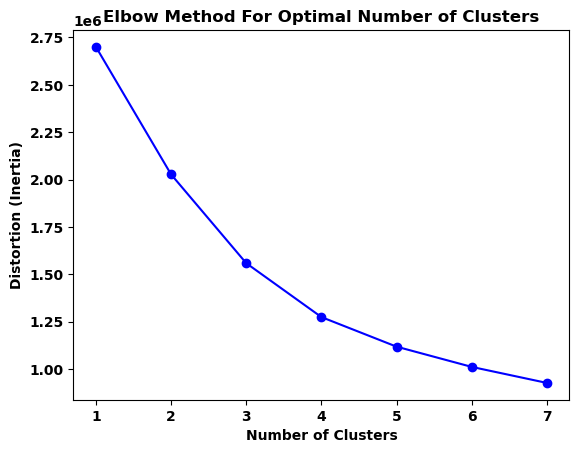

In [6]:
feature_columns = ['SpO2', 'PulseRate', 'Snore']
features = edf_data[feature_columns]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

distortions = []
K = range(1, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=8)
    kmeans.fit(features_scaled)
    distortions.append(kmeans.inertia_)

plt.figure()
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [7]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, n_init=1)
kmeans.fit(features_scaled)

KMeans(n_clusters=4, n_init=1)

In [8]:
labels = kmeans.labels_
edf_data['Cluster'] = labels

In [ ]:
silhouette_avg = silhouette_score(features_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

In [36]:
to_plot=edf_data[['SpO2', 'PulseRate', 'Snore','Cluster']]

In [37]:
to_plot['Snore_zscore'] = np.abs((to_plot['Snore'] - to_plot['Snore'].mean()) / to_plot['Snore'].std())
to_plot = to_plot[to_plot['Snore_zscore'] < 3]
to_plot = to_plot[['SpO2', 'PulseRate', 'Snore','Cluster']]

C:\Users\bruno\AppData\Local\Temp\ipykernel_20240\337452347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['Snore_zscore'] = np.abs((to_plot['Snore'] - to_plot['Snore'].mean()) / to_plot['Snore'].std())


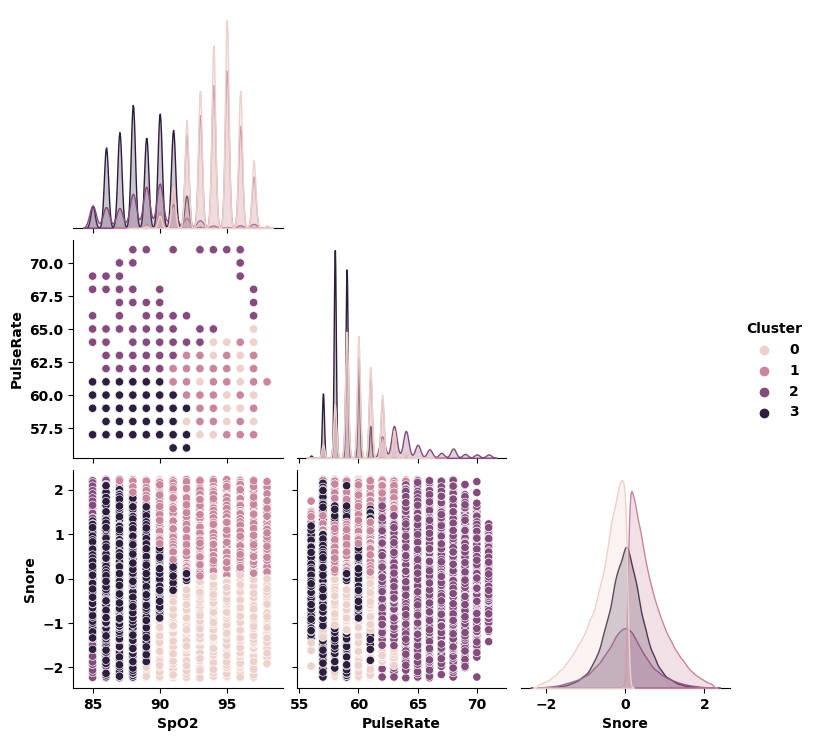

In [38]:
sns.pairplot(to_plot, hue='Cluster', diag_kind="kde", corner=True)
plt.show()



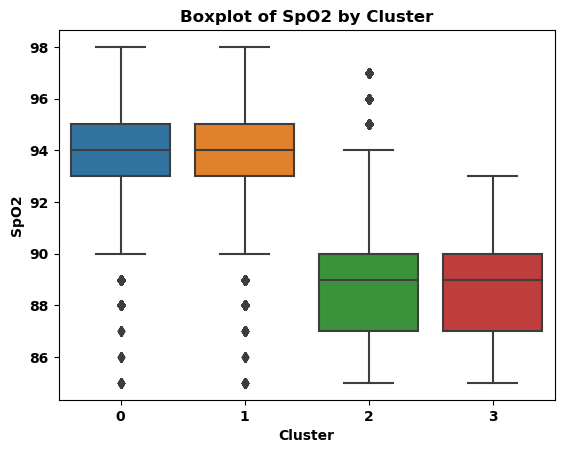

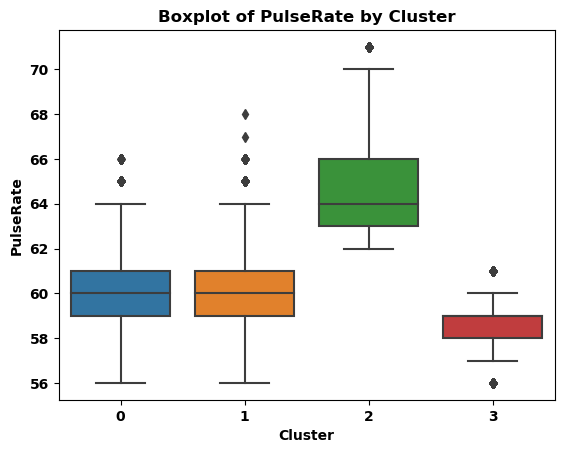

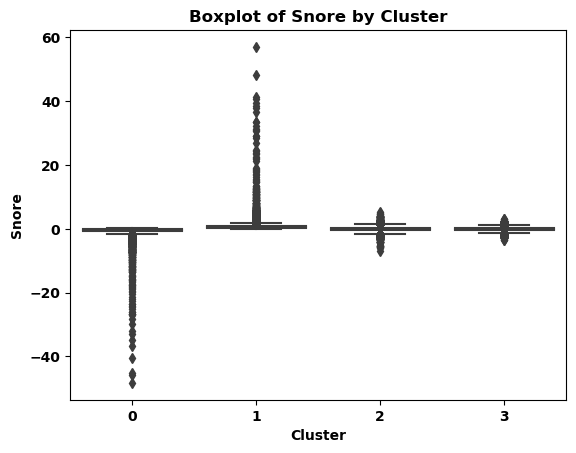

In [39]:
for col in feature_columns:
    plt.figure()
    sns.boxplot(x='Cluster', y=col, data=edf_data)
    plt.title(f'Boxplot of {col} by Cluster')
    plt.show()